# Mapping forest mask

For this step we use band and spectral indicies features to train the model to provide binary classification of the area, where target classes are: <br>
* forest <br>
* non-forest <br>

1. We use unitial dataset with inventory plots buffered with the radius x5
2. Additionally, ground truth plots with other classes are added as non-forest classes
3. The sample from (1) and (2) is labelled with 1 to forest classes and 0 to non-forest classes
3. Final dataset is splitted to 70/30 train/test data
4. Simple algorithms are chosen to perform classification
* RF / RF after grid search
* SVC/ SVC after grid search
* XGBoost

In [1]:
#libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#clustering
from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from yellowbrick.cluster import KElbowVisualizer
#for PCA option
from sklearn.decomposition import PCA

#ML
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data download

In [3]:
ls

Clustering.ipynb                   test_data_radius_X2.csv
Clustering_step.ipynb              test_data_radius_X3.csv
Forest cover mapping (mask).ipynb  test_data_radius_X4.csv
__pycache__/                       test_data_radius_X5.csv
test_data-х3.csv                   utils.py
test_data_actual_radius.csv


In [4]:
test_a = pd.read_csv('test_data_actual_radius.csv', index_col=0)
test_X2 = pd.read_csv('test_data_radius_X2.csv', index_col=0)
test_X3 = pd.read_csv('test_data_radius_X3.csv', index_col=0)
test_X4 = pd.read_csv('test_data_radius_X4.csv', index_col=0)
test_X5 = pd.read_csv('test_data_radius_X5.csv', index_col=0)

In [5]:
print('Number of samples, features in initial dataset', test_a.shape,
      '\nNumber of samples, features in dataset with radius X2', test_X2.shape,
      '\nNumber of samples, features in dataset with radius X3', test_X3.shape,
      '\nNumber of samples, features in dataset with radius X4', test_X4.shape,
      '\nNumber of samples, features in dataset with radius X5', test_X5.shape)
print()
print('Percent of non-forest pixels in initial dataset',len(test_a[test_a['class']>7])/len(test_a)*100,
      '\nPercent of non-forest pixels in dataset with radius X2', len(test_X2[test_X2['class']>7])/len(test_X2)*100, 
      '\nPercent of non-forest pixels in dataset with radius X3', len(test_X3[test_X3['class']>7])/len(test_X3)*100,
      '\nPercent of non-forest pixels in dataset with radius X4', len(test_X4[test_X4['class']>7])/len(test_X4)*100,
      '\nPercent of non-forest pixels in dataset with radius X5', len(test_X5[test_X5['class']>7])/len(test_X5)*100
     )

Number of samples, features in initial dataset (8743, 23) 
Number of samples, features in dataset with radius X2 (14292, 23) 
Number of samples, features in dataset with radius X3 (22358, 23) 
Number of samples, features in dataset with radius X4 (32976, 23) 
Number of samples, features in dataset with radius X5 (46097, 23)

Percent of non-forest pixels in initial dataset 59.670593617751344 
Percent of non-forest pixels in dataset with radius X2 36.50293870696893 
Percent of non-forest pixels in dataset with radius X3 23.333929689596562 
Percent of non-forest pixels in dataset with radius X4 15.820596797671033 
Percent of non-forest pixels in dataset with radius X5 11.31743931275354


It is worth to build models on pixels extention up to X3

## Data preparation step -- filtering with K means

In [6]:
# extraction of forest data to filter pixels
mask = test_X3['class']<8
test_X3_f = test_X3.loc[mask]

In [7]:
from utils import get_cluster_pixels, get_selection

In [8]:
clustered_df_a = pd.DataFrame() #initial dataset to filter

for item in test_a.loc[test_a['class']<8].key.unique():
    attmpt = get_cluster_pixels(test_a.loc[test_a['class']<8],
                                key=item,
                                correlation_threshold=0.7, 
                                max_number_of_clusters=4)
    attmpt = get_selection(attmpt)
    clustered_df_a = pd.concat([clustered_df_a, attmpt])
    print('.', end='')
    
    
clustered_df_X2 = pd.DataFrame() #dataset with radius X2 to filter

for item in test_X2.loc[test_X2['class']<8].key.unique():
    attmpt = get_cluster_pixels(test_X2.loc[test_X2['class']<8],
                                key=item,
                                correlation_threshold=0.7, 
                                max_number_of_clusters=4)
    attmpt = get_selection(attmpt)
    clustered_df_X2 = pd.concat([clustered_df_X2, attmpt])
    print('.', end='')
    
    
clustered_df_X3 = pd.DataFrame() #dataset with radius X3 to filter

for item in test_X3.loc[test_X3['class']<8].key.unique():
    attmpt = get_cluster_pixels(test_X3.loc[test_X3['class']<8],
                                key=item,
                                correlation_threshold=0.7, 
                                max_number_of_clusters=4)
    attmpt = get_selection(attmpt)
    clustered_df_X3 = pd.concat([clustered_df_X3, attmpt])
    print('.', end='')    

.......equal cluster
............equal cluster
...........equal cluster
.equal cluster
...equal cluster
.........equal cluster
.....equal cluster
.equal cluster
....equal cluster
.............equal cluster
.......equal cluster
...equal cluster
........equal cluster
....equal cluster
.............equal cluster
.........equal cluster
..equal cluster
.........equal cluster
......equal cluster
.....equal cluster
....equal cluster
...................equal cluster
...equal cluster
.........equal cluster
...........equal cluster
...equal cluster
.......equal cluster
.........equal cluster
...equal cluster
..equal cluster
.....equal cluster
...equal cluster
..equal cluster
....equal cluster
.......equal cluster
...equal cluster
.equal cluster
.....equal cluster
..........equal cluster
.equal cluster
...equal cluster
......equal cluster
.equal cluster
.equal cluster
.equal cluster
...........equal cluster
.......equal cluster
.equal cluster
...........equal cluster
.........equal cluster
.equal

In [10]:
#merge filtered forest data with non-forest pixels
filtered_df_a = pd.concat([clustered_df_a, test_a.loc[test_a['class']>7]]).iloc[:,:-1]
filtered_df_x2 = pd.concat([clustered_df_X2, test_X2.loc[test_X2['class']>7]]).iloc[:,:-1]
filtered_df_x3 = pd.concat([clustered_df_X3, test_X3.loc[test_X3['class']>7]]).iloc[:,:-1]


#prediction class 'forest' is added
filtered_df_a['forest'] = np.where(filtered_df_a['class']<8, 1, 0)
filtered_df_x2['forest'] = np.where(filtered_df_x2['class']<8, 1, 0)
filtered_df_x3['forest'] = np.where(filtered_df_x3['class']<8, 1, 0)

## Pixels distribution among classes

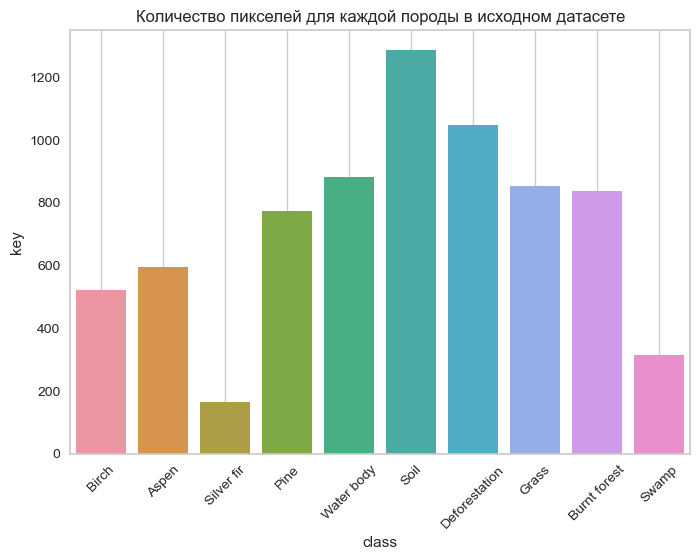

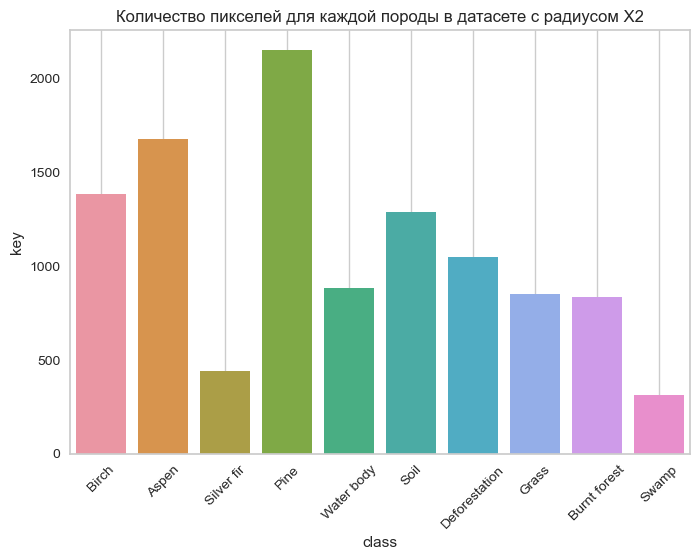

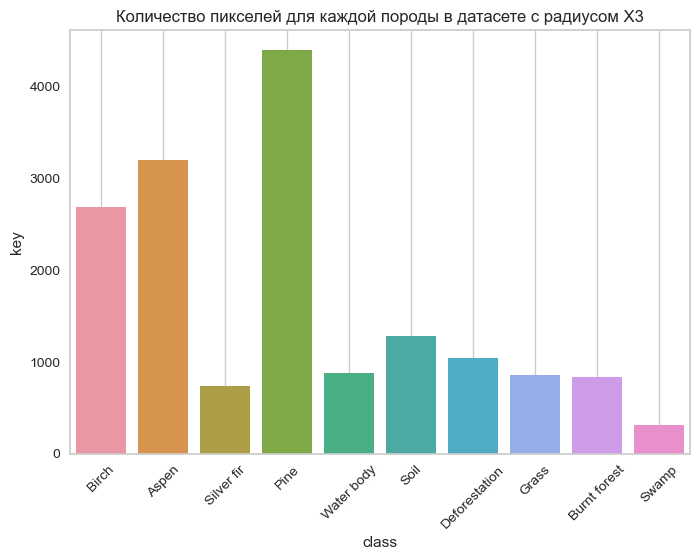

In [11]:
dict_normal_names={7: "Pine", 
        2:"Fir", 
        5:"Aspen",
        3:"Cedar",
        4:"Larch",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body'}
pixels_per_class = filtered_df_a.groupby('class', as_index=False).count()
pixels_per_class['class'] = pixels_per_class['class'].apply(lambda x: dict_normal_names[x])
sns.barplot(data=pixels_per_class, x='class', y='key')
plt.grid()
plt.title('Количество пикселей для каждой породы в исходном датасете')
plt.xticks(rotation=45)
plt.show()


pixels_per_class = filtered_df_x2.groupby('class', as_index=False).count()
pixels_per_class['class'] = pixels_per_class['class'].apply(lambda x: dict_normal_names[x])
sns.barplot(data=pixels_per_class, x='class', y='key')
plt.grid()
plt.title('Количество пикселей для каждой породы в датасете с радиусом Х2')
plt.xticks(rotation=45)
plt.show()


pixels_per_class = filtered_df_x3.groupby('class', as_index=False).count()
pixels_per_class['class'] = pixels_per_class['class'].apply(lambda x: dict_normal_names[x])
sns.barplot(data=pixels_per_class, x='class', y='key')
plt.grid()
plt.title('Количество пикселей для каждой породы в датасете с радиусом Х3')
plt.xticks(rotation=45)
plt.show()

## Random forest

### Initial dataset

In [12]:
from random import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [13]:
filtered_df_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7274 entries, 3 to 10
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   B01           7274 non-null   float64
 1   B02           7274 non-null   float64
 2   B03           7274 non-null   float64
 3   B04           7274 non-null   float64
 4   B05           7274 non-null   float64
 5   B06           7274 non-null   float64
 6   B07           7274 non-null   float64
 7   B08           7274 non-null   float64
 8   B8A           7274 non-null   float64
 9   B09           7274 non-null   float64
 10  B11           7274 non-null   float64
 11  B12           7274 non-null   float64
 12  NDVI          7274 non-null   float64
 13  EVI           7274 non-null   float64
 14  MSAVI         7274 non-null   float64
 15  NDRE          7274 non-null   float64
 16  FCI           7274 non-null   float64
 17  aspect        7274 non-null   float64
 18  slope         7274 non-null   

In [14]:
to_drop = ['forest','key', 'class']

In [15]:
X = filtered_df_a.drop(to_drop, axis=1)

y = filtered_df_a['forest']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [17]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((5091, 21), (2183, 21))

#### Simple classifier

In [19]:
# instantiate simple classifier 
rfc = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model
rfc.fit(X_train, y_train)


# Predict the Test set results
y_pred = rfc.predict(X_test)

In [20]:
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.9995


Confusion matrix

 [[1548    1]
 [   0  634]]


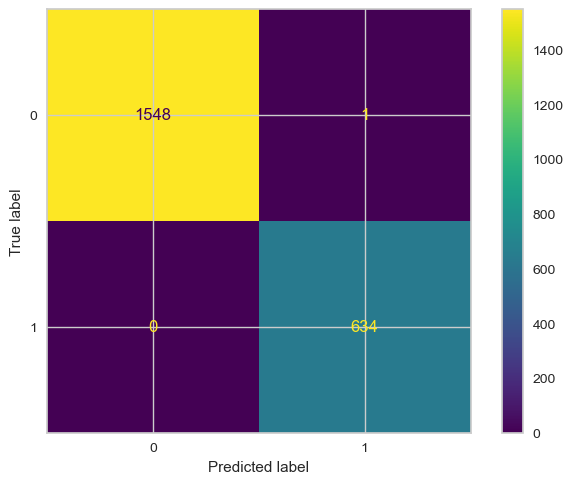

In [23]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1549
           1       1.00      1.00      1.00       634

    accuracy                           1.00      2183
   macro avg       1.00      1.00      1.00      2183
weighted avg       1.00      1.00      1.00      2183



#### Feature importance

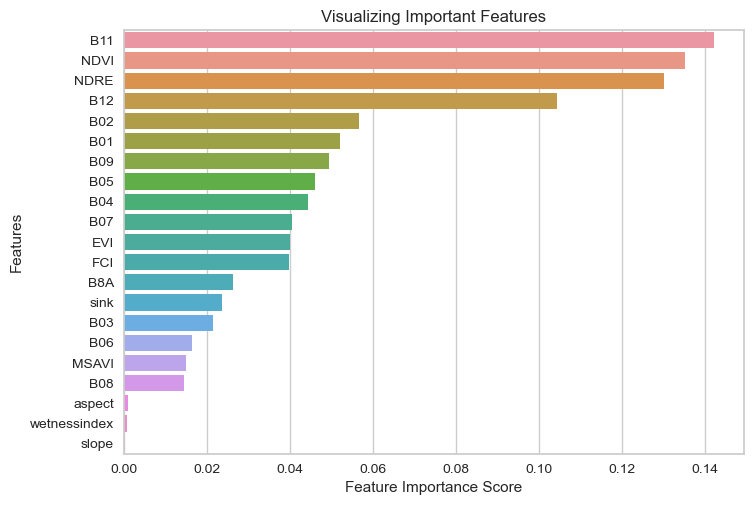

In [21]:
# create the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model to the training set

clf.fit(X_train, y_train)
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)


# Creating a seaborn bar plot

sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
# Add title to the graph
plt.title("Visualizing Important Features")

plt.show()

#### Taking only important features


In [27]:
top_5_features = feature_scores.head(5).index.tolist()

In [28]:
X = filtered_df_a[top_5_features]

y = filtered_df_a['forest']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [31]:
# instantiate the classifier 

rfc = RandomForestClassifier(n_estimators=100, random_state=0)



# fit the model

rfc.fit(X_train, y_train)



# Predict the Test set results

y_pred = rfc.predict(X_test)

In [32]:
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.9954


Confusion matrix

 [[1540    9]
 [   1  633]]


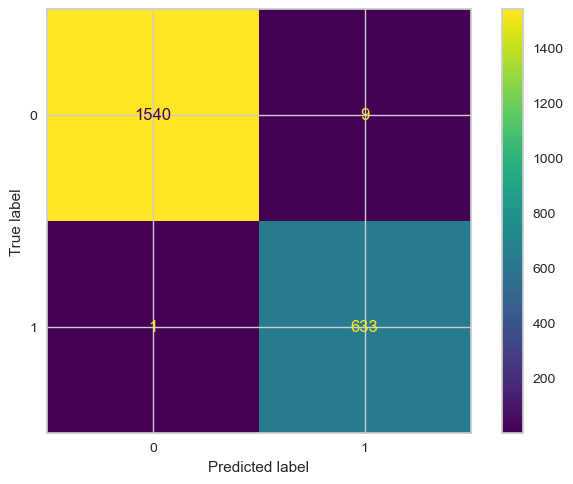

In [33]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

#### Grid search: best model parameters RF

In [34]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [36]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [69]:
print(rf_random.best_params_)
print(rf_random.best_estimator_)

{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, max_depth=60, min_samples_split=5,
                       n_estimators=600)


In [68]:
rfc_best_params = rf_random.best_estimator_



# fit the model

rfc_best_params.fit(X_train, y_train)



# Predict the Test set results

y_pred = rfc.predict(X_test)

In [70]:
print('Training Accuracy : ',
      metrics.accuracy_score(y_train,
                             model.predict(X_train))*100)
print('Validation Accuracy : ',
      metrics.accuracy_score(y_test,
                             model.predict(X_test))*100)

Training Accuracy :  100.0
Validation Accuracy :  99.54191479615208


Confusion matrix

 [[1540    9]
 [   1  633]]


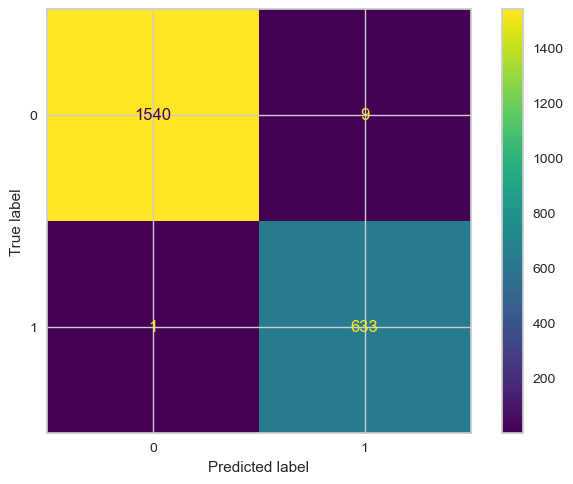

In [71]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Conclusion: I think it's overfitted eitherway

## SVC

In [56]:
#feature scaling
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [58]:
#linear kernel
svc = SVC(C=1.0, random_state=1, kernel='linear')
 
# Fit the model
svc.fit(X_train_std, y_train)

SVC(kernel='linear', random_state=1)

In [59]:
# Make the predictions
y_predict = svc.predict(X_test_std)
 
# Measure the performance
print("Accuracy score %.3f" %metrics.accuracy_score(y_test, y_predict))

Accuracy score 0.987


In [61]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1549
           1       0.97      0.99      0.98       634

    accuracy                           0.99      2183
   macro avg       0.98      0.99      0.98      2183
weighted avg       0.99      0.99      0.99      2183



Confusion matrix

 [[1528   21]
 [   7  627]]


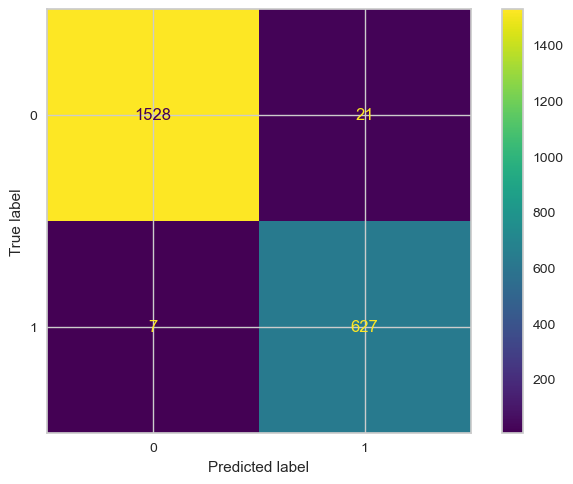

In [62]:
cm = confusion_matrix(y_test, y_predict)

print('Confusion matrix\n\n', cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

#### Grid search: best model parameters: SVC

In [65]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.967 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.964 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.959 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.967 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.969 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.720 total time=   0.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.721 total time=   0.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.721 total time=   0.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.720 total time=   0.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.720 total time=   0.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.720 total time=   0.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.994 total time=   0.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.989 total time=   0.1s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.989 total time=   0.1s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.984 total time=   0.1s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.992 total time=   0.1s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.983 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.986 total time=   0.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.976 total time=   0.1s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.979 total time=   0.1s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.983 total time=   0.1s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.978 total time=   0.1s
[CV 2/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [66]:
# best parameter after tuning
print(grid.best_params_)
  
# model after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1000, gamma=1)


In [83]:
svc_linear_grid = grid.best_estimator_.fit(X_train, y_train)
y_pred_svc = svc_linear_grid.predict(X_test)

In [81]:
print('Training Accuracy : ',
      metrics.accuracy_score(y_train,
                             svc_linear_grid.predict(X_train))*100)
print('Validation Accuracy : ',
      metrics.accuracy_score(y_test,
                             svc_linear_grid.predict(X_test))*100)

Training Accuracy :  98.97858966804164
Validation Accuracy :  98.67155290884104


In [90]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1549
           1       0.96      0.99      0.98       634

    accuracy                           0.99      2183
   macro avg       0.98      0.99      0.98      2183
weighted avg       0.99      0.99      0.99      2183



Confusion matrix

 [[1526   23]
 [   6  628]]


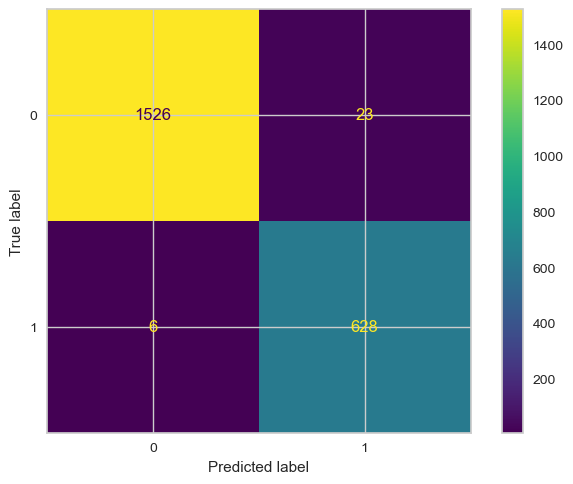

In [88]:
cm = confusion_matrix(y_test, y_pred_svc)

print('Confusion matrix\n\n', cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## XGBoost Classifier

In [113]:
from xgboost import XGBClassifier

#### Simple model

In [116]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [117]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [120]:
y_pred_xgb = xgb_model.predict(X_test)

In [121]:
print('Training Accuracy : ',
      metrics.accuracy_score(y_train,
                             xgb_model.predict(X_train))*100)
print('Validation Accuracy : ',
      metrics.accuracy_score(y_test,
                             xgb_model.predict(X_test))*100)

Training Accuracy :  100.0
Validation Accuracy :  99.72514887769125
